In [1]:
# import libraries
import math

import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch

from core.koopman_core_linear import KoopDNN_linear, KoopmanNet_linear, KoopmanNetCtrl_linear
from sklearn import preprocessing
from core.util import fit_standardizer
from models.koop_model import model_matricies,lift

from core.adapt_net_linear_test import AdaptNet_linear
import scipy.io

from dynamics.robot_3R import dynamics_3R, dynamics_3R_data_gen, forward_map_3R, get_robot_params
import time

In [2]:
dt = 0.005 #time step
num_snaps = 1000 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 100 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = 6 # no. of states
num_inputs = 3 # no. of inputs

In [3]:
# Oscillator parameters
robot_pars = {}
# link lengths
robot_pars['a1'] = 0.33
robot_pars['a2'] = 0.33
robot_pars['a3'] = 0.33

robot_pars['del_a1'] = 0.
robot_pars['del_a2'] = 0.
robot_pars['del_a3'] = 0.


#link masses
robot_pars['m1'] = 0.1
robot_pars['m2'] = 0.1
robot_pars['m3'] = 0.1

robot_pars['del_m1'] = 0.1
robot_pars['del_m2'] = 0.1
robot_pars['del_m3'] = 0.1

# link inertias
robot_pars['I1'] = 1
robot_pars['I2'] = 1
robot_pars['I3'] = 1

robot_pars['del_I1'] = 0.5
robot_pars['del_I2'] = 0.5
robot_pars['del_I3'] = 0.5

#position of CM
robot_pars['l1'] = 0.33/2
robot_pars['l2'] = 0.33/2
robot_pars['l3'] = 0.33/2

robot_pars['del_l1'] = 0
robot_pars['del_l2'] = 0
robot_pars['del_l3'] = 0

#dynamic friction coefficient
robot_pars['fd'] = 0.1

robot_pars['del_fd'] = 0


robot_pars['delay'] = False
robot_pars['delay_time'] = 5
robot_pars['cont_unc_type'] = 'constant'

In [4]:
X_end_changed,X_changed, X_end_unchanged, X_unchanged, U = dynamics_3R_data_gen(dt,num_traj, num_snaps,num_states,num_inputs,robot_pars)

print(X_changed.shape, U.shape)

(125, 1001, 6) (125, 1000, 3)


In [5]:
# Check for nan values
print(sum(sum(sum(np.isnan(X_changed)))))
print(sum(sum(sum(np.isnan(X_unchanged)))))

0
0


In [6]:
l2_diff = np.linalg.norm(X_changed-X_unchanged)/((X_changed.size)**(1/2))
print('l2_diff = ', l2_diff)

l2_diff =  0.03814795540922317


In [7]:
change_in_dym = np.linalg.norm((X_changed-X_unchanged)/X_changed)/X_changed.size
print('fraction of change in dynamics = ', change_in_dym)

fraction of change in dynamics =  0.169014876672818


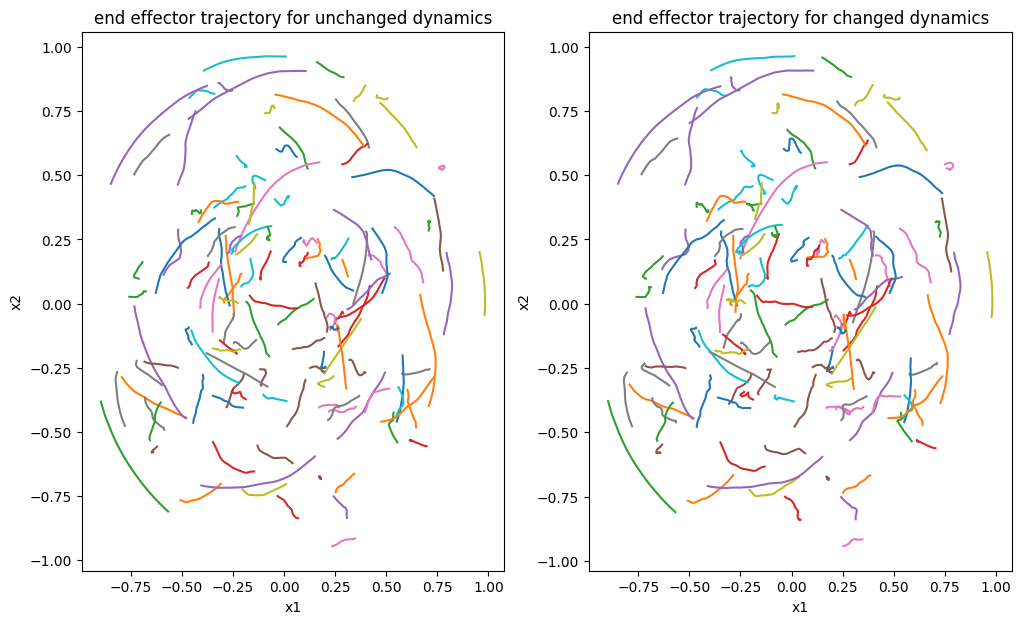

In [8]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("end effector trajectory for unchanged dynamics")
axs[1].set_title("end effector trajectory for changed dynamics")

axs[0].set(xlabel = 'x1', ylabel = 'x2')
axs[1].set(xlabel = 'x1', ylabel = 'x2')

for i in range(num_traj):
    axs[0].plot(X_end_unchanged[i,:,0], X_end_unchanged[i,:,1])
    axs[1].plot(X_end_changed[i,:,0], X_end_changed[i,:,1])
plt.savefig('phase_plot_duffing.jpg')

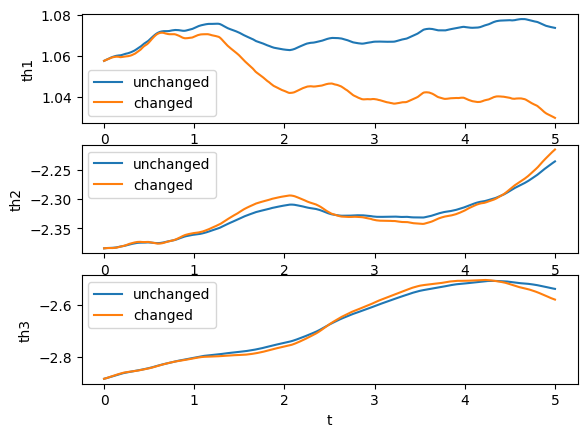

In [9]:
plt.figure()

j = 10
for i in range(int(num_states/2)):
    plt.subplot(3,1,i+1)
    plt.xlabel("t")
    plt.ylabel("th"+str(i+1))
    plt.plot(T,X_unchanged[j,:,i], label = 'unchanged')
    plt.plot(T,X_changed[j,:,i], label = 'changed')
    plt.legend()
        


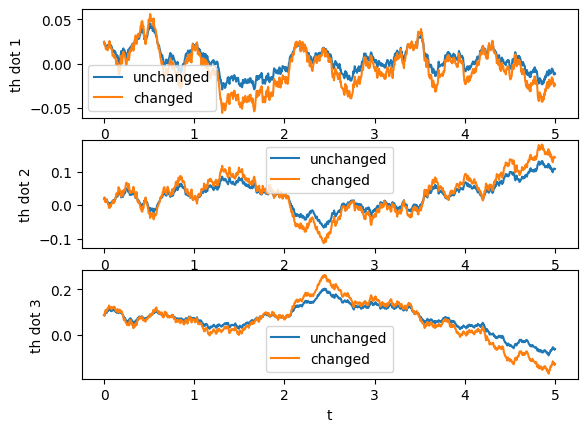

In [10]:
j = 10
for i in range(int(num_states/2)):
    plt.subplot(3,1,i+1)
    plt.xlabel("t")
    plt.ylabel("th dot "+str(i+1))
    plt.plot(T,X_unchanged[j,:,3+i], label = 'unchanged')
    plt.plot(T,X_changed[j,:,3+i], label = 'changed')
    plt.legend()

In [11]:
# split training and vaidation datasets
xs_train, us_train = X_unchanged[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X_unchanged[num_train:,:,:],U[num_train:,:,:]

***Koopman bilinear Models***

In [12]:
# auto encoder parameters

net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 30
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 10
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 5e-4 # 5e-4
net_params['epochs'] = 100
net_params['batch_size'] = 256
net_params['lifted_loss_penalty'] = 0.3
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0.0
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifted state
net_params['dt'] = dt

In [13]:
train = False

if train == True:
    file = 'saved_models/3R/linear/3R_0_01_dim10.pth'
    net = KoopmanNetCtrl_linear(net_params)
    model_koop_dnn = KoopDNN_linear(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file)
else:
    file = 'saved_models/3R/linear/3R_0_01_dim10.pth'
    model_koop_dnn = torch.load(file)

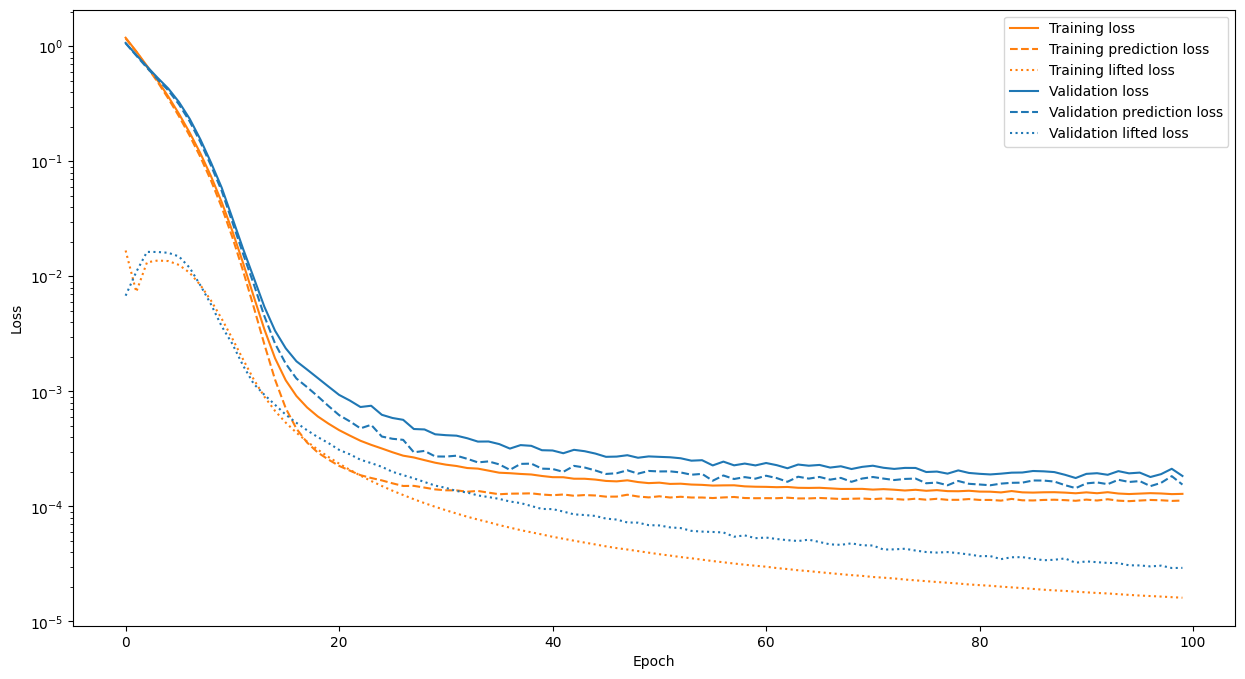

In [14]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

# Learned Model Parameters

## Bilinear Model Parameters

In [15]:
A = np.array(model_koop_dnn.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn.C)

print(A.shape, B.shape, C.shape)

(17, 17) (17, 3) (6, 17)


In [16]:
# # SAVE MATRIX PARAMETERS AS MATLAB FILE
# import scipy.io
#
# dyn_matrices = {"A": A, "B": B, "C": C}
# scipy.io.savemat("dyn_mat.mat", dyn_matrices)
# #save encoder parameters
# scipy.io.savemat("in_weights.mat", {"encode_in_weights": model_koop_dnn.net.encoder_fc_in.weight.detach().numpy()})
# scipy.io.savemat("in_bias.mat", {"encode_in_bias": model_koop_dnn.net.encoder_fc_in.bias.detach().numpy()})
#
# scipy.io.savemat("hidden_weights_1.mat",
#                  {"encode_hidden_weights_1": model_koop_dnn.net.encoder_fc_hid[0].weight.detach().numpy()})
# scipy.io.savemat("hidden_bias_1.mat",
#                  {"encode_hidden_bias_1": model_koop_dnn.net.encoder_fc_hid[0].bias.detach().numpy()})
#
# scipy.io.savemat("out_weights.mat", {"encode_out_weights": model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()})
# scipy.io.savemat("out_bias.mat", {"encode_out_bias": model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()})

## Lifting function

# Testing

## Parameters

In [17]:
# test data parameters
num_snaps_test = 2000 # no. of snapshots
T_test = np.linspace(0,num_snaps_test*dt, num_snaps_test+1)
num_traj_test = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

## Testing Data

In [18]:
x_end_changed_test,x_changed_test,x_end_unchanged_test, x_unchanged_test, u_test = dynamics_3R_data_gen(dt, num_traj_test, num_snaps_test,num_states, num_inputs, robot_pars)
print(model_koop_dnn.test_loss(x_unchanged_test,u_test = u_test))

tensor(7.4268e-05)


In [19]:
x_unchanged_test.shape

(1, 2001, 6)

In [20]:
# Use the preprocessing if available
X_unchanged,_ = model_koop_dnn.net.process(x_unchanged_test,data_u = u_test)
X_changed,_ = model_koop_dnn.net.process(x_changed_test,data_u = u_test)

In [21]:
X_changed.shape

(2000, 15)

In [22]:
# flatten vector
x_unchanged = X_unchanged[:, :num_states]
u = X_unchanged[:, num_states:num_states+num_inputs]
x_unchanged_prime = X_unchanged[:,num_states+num_inputs:]

x_changed = X_changed[:, :num_states]
x_changed_prime = X_changed[:,num_states+num_inputs:]

x_changed_dot = (x_changed_prime-x_changed)/dt
print(x_changed.shape, u.shape, x_changed_prime.shape)

(2000, 6) (2000, 3) (2000, 6)


# Lifting of states

In [23]:
# initialize states
# initialize the matricies
z_unchanged = np.empty((n_obs,num_snaps_test+1)).T   #lifted state
x_unchanged_est = np.zeros((num_states,num_snaps_test+1)).T #estimated values

In [24]:
x_unchanged[0,:].shape

(6,)

In [25]:
# actual lift
z_unchanged[0,:] = lift(x_unchanged[0,:],model_koop_dnn, net_params)
x_unchanged_est[0,:] = x_unchanged[0,:]

# Time Evolution

In [26]:
for i in range(num_snaps_test):
  #bilinear
    z_unchanged[i+1,:] = np.matmul(z_unchanged[i,:],A.T)+np.matmul(u[i,:],B.T)
    x_unchanged_est[i+1,:] = np.matmul(z_unchanged[i+1,:],C.T)

# Plotting

## Lifting performance

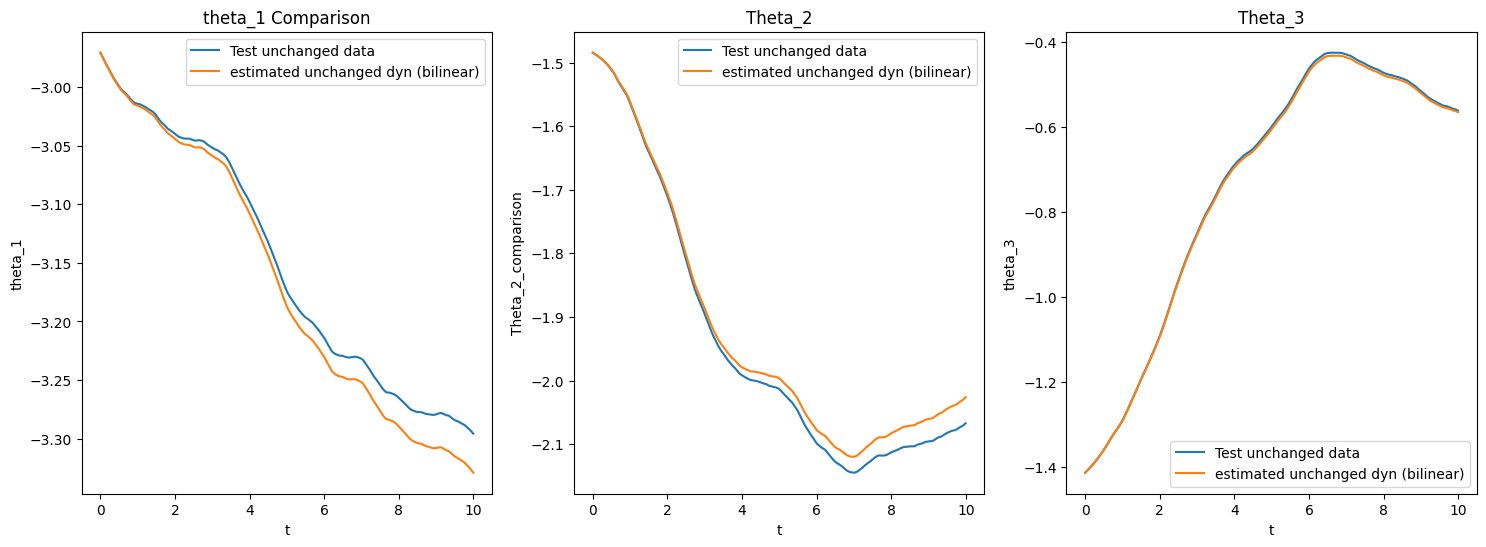

In [27]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(T_test[:-1],x_unchanged[:,0],label ='Test unchanged data')
plt.plot(T_test,x_unchanged_est[:,0],label = 'estimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('theta_1')
plt.title('theta_1 Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(T_test[:-1],x_unchanged[:,1],label ='Test unchanged data')
plt.plot(T_test,x_unchanged_est[:,1],label = 'estimated unchanged dyn (bilinear)')
plt.title('Theta_2')
plt.xlabel('t')
plt.ylabel('Theta_2_comparison')
plt.legend()

plt.subplot(1,3,3)
plt.plot(T_test[:-1],x_unchanged[:,2],label ='Test unchanged data')
plt.plot(T_test,x_unchanged_est[:,2],label = 'estimated unchanged dyn (bilinear)')
plt.title('Theta_3')
plt.xlabel('t')
plt.ylabel('theta_3')
plt.legend()

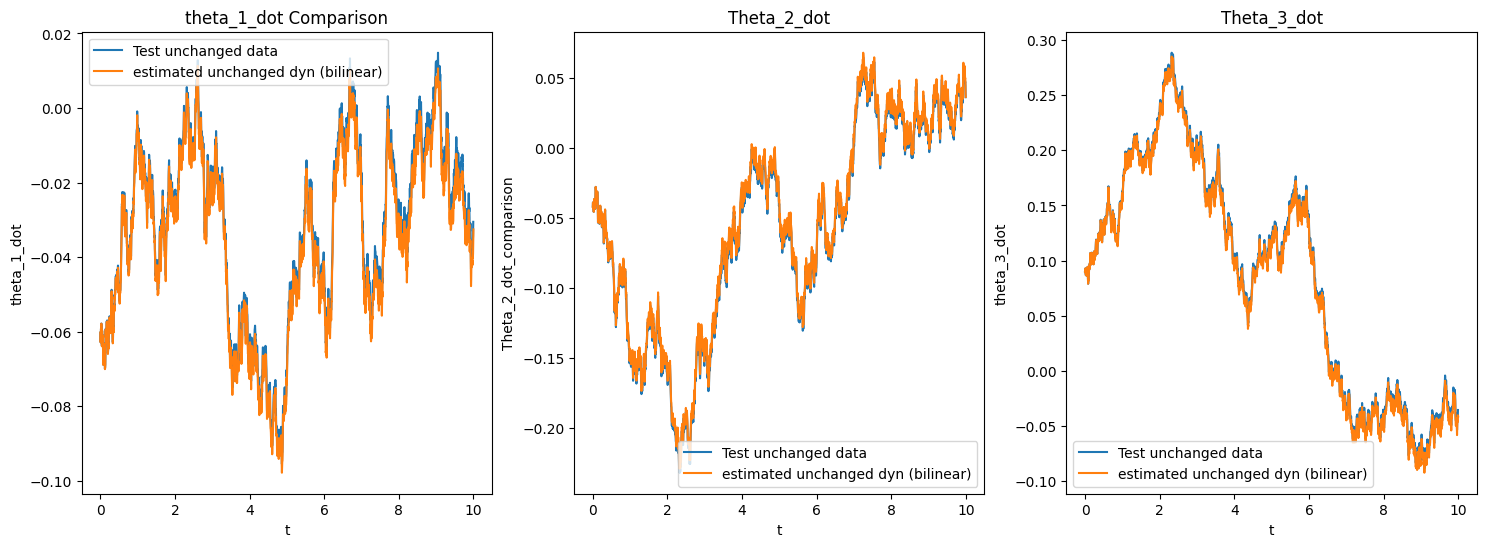

In [28]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(T_test[:-1],x_unchanged[:,3],label ='Test unchanged data')
plt.plot(T_test,x_unchanged_est[:,3],label = 'estimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('theta_1_dot')
plt.title('theta_1_dot Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(T_test[:-1],x_unchanged[:,4],label ='Test unchanged data')
plt.plot(T_test,x_unchanged_est[:,4],label = 'estimated unchanged dyn (bilinear)')
plt.title('Theta_2_dot')
plt.xlabel('t')
plt.ylabel('Theta_2_dot_comparison')
plt.legend()

plt.subplot(1,3,3)
plt.plot(T_test[:-1],x_unchanged[:,5],label ='Test unchanged data')
plt.plot(T_test,x_unchanged_est[:,5],label = 'estimated unchanged dyn (bilinear)')
plt.title('Theta_3_dot')
plt.xlabel('t')
plt.ylabel('theta_3_dot')
plt.legend()

### Error Evolution

In [29]:
error_model = np.linalg.norm((x_unchanged_est[:-1,:]-x_unchanged[:,:]),axis=1)
error_dynamics_no_adapt = np.linalg.norm((x_changed[:,:]-x_unchanged[:,:]),axis=1)

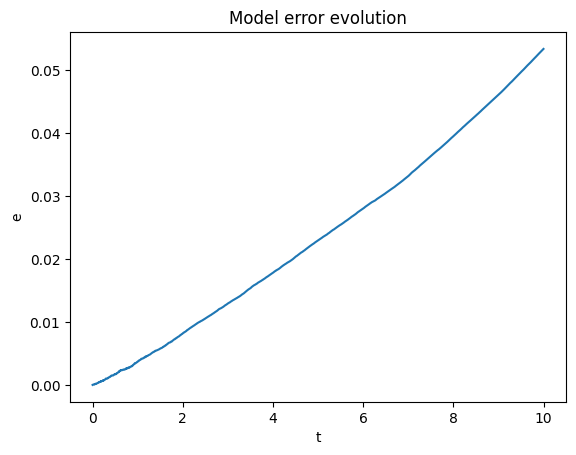

In [30]:
plt.figure()
plt.plot(T_test[:-1],error_model)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Model error evolution')
plt.show()

## Deviation from Actual Dynamics

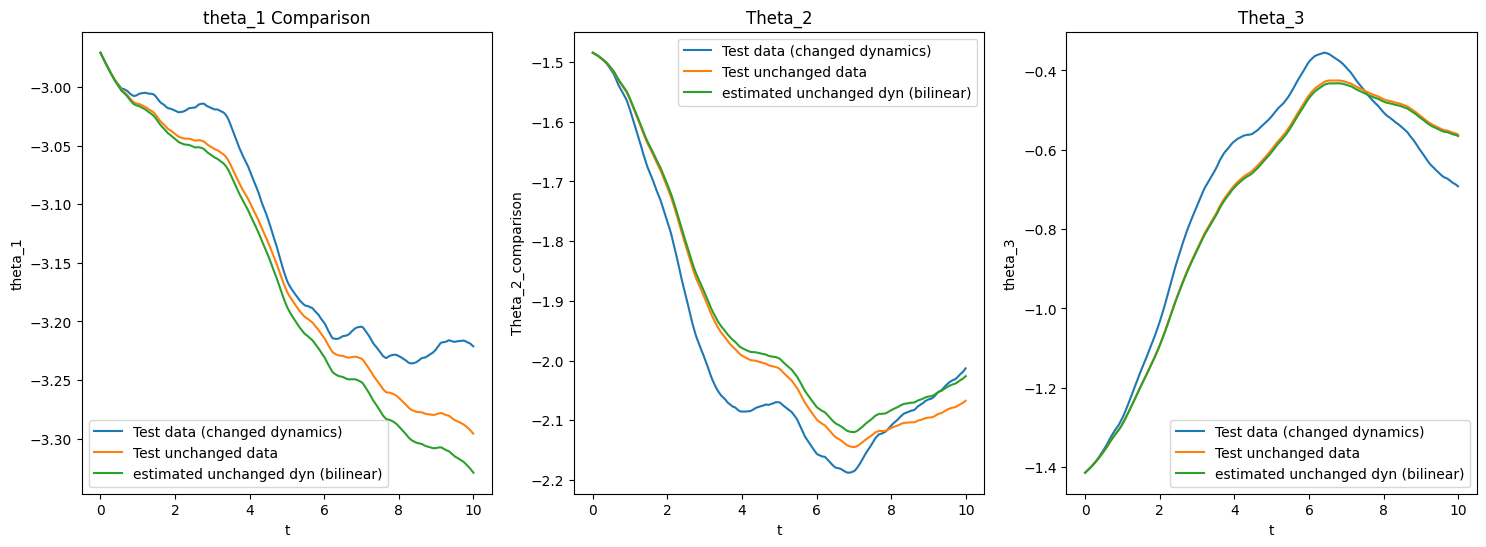

In [31]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(T_test[:-1],x_changed[:,0],label ='Test data (changed dynamics)')
plt.plot(T_test[:-1],x_unchanged[:,0],label ='Test unchanged data')
plt.plot(T_test,x_unchanged_est[:,0],label = 'estimated unchanged dyn (bilinear)')

plt.xlabel('t')
plt.ylabel('theta_1')
plt.title('theta_1 Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(T_test[:-1],x_changed[:,1],label ='Test data (changed dynamics)')
plt.plot(T_test[:-1],x_unchanged[:,1],label ='Test unchanged data')
plt.plot(T_test,x_unchanged_est[:,1],label = 'estimated unchanged dyn (bilinear)')
plt.title('Theta_2')
plt.xlabel('t')
plt.ylabel('Theta_2_comparison')
plt.legend()

plt.subplot(1,3,3)
plt.plot(T_test[:-1],x_changed[:,2],label ='Test data (changed dynamics)')
plt.plot(T_test[:-1],x_unchanged[:,2],label ='Test unchanged data')
plt.plot(T_test,x_unchanged_est[:,2],label = 'estimated unchanged dyn (bilinear)')
plt.title('Theta_3')
plt.xlabel('t')
plt.ylabel('theta_3')
plt.legend()




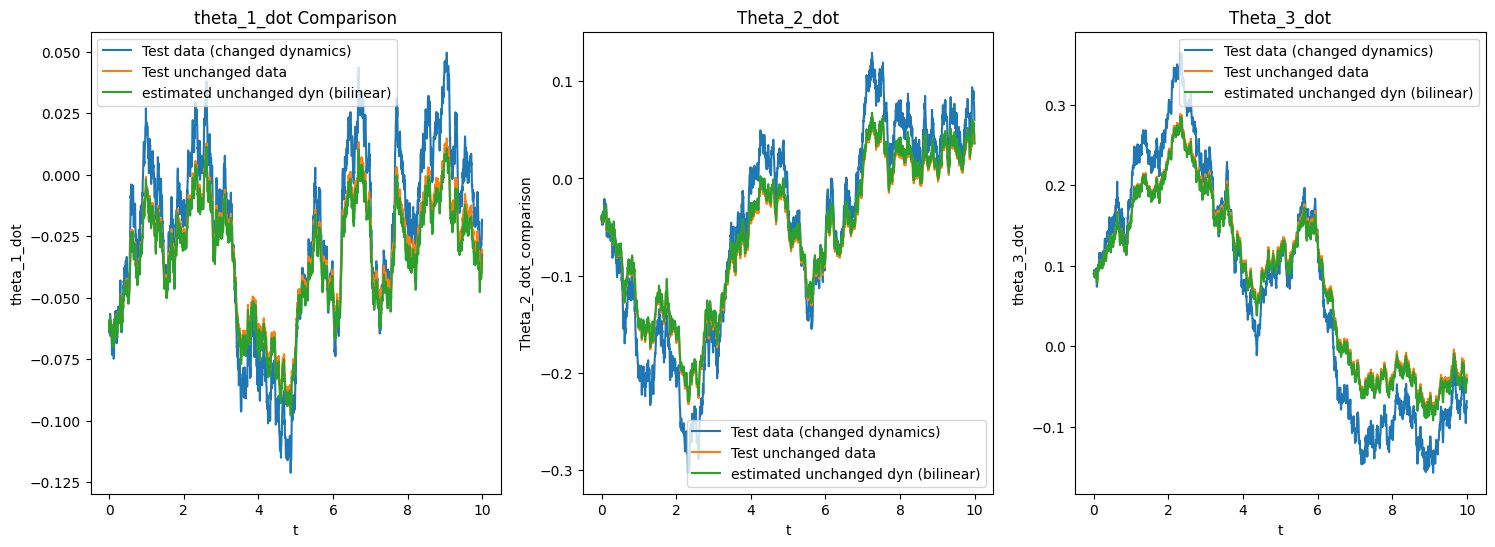

In [32]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(T_test[:-1],x_changed[:,3],label ='Test data (changed dynamics)')
plt.plot(T_test[:-1],x_unchanged[:,3],label ='Test unchanged data')
plt.plot(T_test,x_unchanged_est[:,3],label = 'estimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('theta_1_dot')
plt.title('theta_1_dot Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(T_test[:-1],x_changed[:,4],label ='Test data (changed dynamics)')
plt.plot(T_test[:-1],x_unchanged[:,4],label ='Test unchanged data')
plt.plot(T_test,x_unchanged_est[:,4],label = 'estimated unchanged dyn (bilinear)')
plt.title('Theta_2_dot')
plt.xlabel('t')
plt.ylabel('Theta_2_dot_comparison')
plt.legend()

plt.subplot(1,3,3)
plt.plot(T_test[:-1],x_changed[:,5],label ='Test data (changed dynamics)')
plt.plot(T_test[:-1],x_unchanged[:,5],label ='Test unchanged data')
plt.plot(T_test,x_unchanged_est[:,5],label = 'estimated unchanged dyn (bilinear)')
plt.title('Theta_3_dot')
plt.xlabel('t')
plt.ylabel('theta_3_dot')
plt.legend()

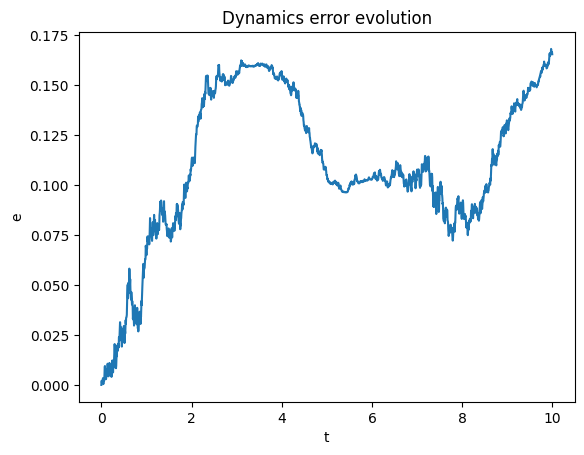

In [33]:
plt.figure()
plt.plot(T_test[:-1],error_dynamics_no_adapt)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Dynamics error evolution')
plt.show()

# Adaptation

## Data Preprocessing

# Adaptive Time evolution

In [244]:
adap_window = 5 #hyperparameter

adapt_net_params = {}
adapt_net_params['state_dim'] = num_states
adapt_net_params['ctrl_dim'] = num_inputs
adapt_net_params['lift_dim'] = net_params["encoder_output_dim"]
adapt_net_params['optimizer'] = 'adam'
adapt_net_params['lr'] = 5e-4 # 5e-4
adapt_net_params['epochs'] = 8
adapt_net_params['batch_size'] = adap_window
adapt_net_params['l2_reg'] = 5e-1
adapt_net_params['l1_reg'] = 5e-1
adapt_net_params['first_obs_const'] = net_params["first_obs_const"]
adapt_net_params['override_C'] = net_params["override_C"] # this makes the state a part of lifted state
adapt_net_params['warm_start'] = False

del_A = np.zeros_like(A)
del_B = np.zeros_like(B)

adapt_net_params['del_A_prev'] = del_A
adapt_net_params['del_B_prev'] = del_B


In [245]:
from control_files.nmpc_osqp_adapt import NonlinearMPCController
from dynamics.learned_models_control.linear_dynamics import linear_Dynamics
import scipy

In [246]:
linear_model = linear_Dynamics(scipy.sparse.csc_matrix(A),scipy.sparse.csc_matrix(B), C)
linear_model_no_adapt = linear_Dynamics(scipy.sparse.csc_matrix(A),scipy.sparse.csc_matrix(B), C)

In [247]:
linear_model.A

<17x17 sparse matrix of type '<class 'numpy.float32'>'
	with 273 stored elements in Compressed Sparse Column format>

In [248]:
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 3
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = False
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 1000
solver_settings['eps_abs'] = 1e-5
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

In [249]:
#Closed loop performance evaluation parameters:
traj_length = 1000
max_iter = 200
N = 15 #length of horizon
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
Q_mpc = 6e3*scipy.sparse.diags(np.ones(num_states))                       # State penalty matrix, trajectory generation
QN_mpc = 1e3*scipy.sparse.diags(np.ones(num_states))         # Final state penalty matrix, trajectory generation
R_mpc = 1*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
R0_mpc = scipy.sparse.csc_matrix(np.zeros(num_inputs))

In [250]:
## linear path
# x_ref = np.vstack((np.vstack((np.linspace(0,np.pi,num_snaps_ctrl),np.linspace(0,np.pi/2,num_snaps_ctrl))),np.linspace(0,np.pi,num_snaps_ctrl)))
# x_ref_dot = np.vstack((np.vstack(((np.pi/10)*np.ones(num_snaps_ctrl),(np.pi/20)*np.ones(num_snaps_ctrl))),(np.pi/10)*np.ones(num_snaps_ctrl)))
# x_ref_ddot = np.vstack((np.vstack((np.zeros(num_snaps_ctrl),np.zeros(num_snaps_ctrl))),np.zeros(num_snaps_ctrl)))

def gen_desired_path(num_states,num_snaps, t_end,shape):
    
    x_ref = np.empty((int(num_states),num_snaps))
    x_ref_dot = np.empty_like(x_ref)
    x_ref_ddot = np.empty_like(x_ref)
    
    arg = np.linspace(0,np.pi,num_snaps)
    
    for i in range(num_snaps):
        if shape == 'linear':
            x_ref[:,i] = np.array([arg[i], arg[i]/2, arg[i]])
            x_ref_dot[:,i] = np.array([arg[-1]/t_end, arg[-1]/(2*t_end), arg[-1]/(t_end)])
            x_ref_ddot[:,i] = np.zeros(num_states,)
            
        if shape == 'sinosoidal':
            x_ref[:,i] = np.array([np.sin(2*arg[i]),np.sin(2*arg[i]) , np.sin(2*arg[i])])
            x_ref_dot[:,i] = np.array([(2*arg[-1]/t_end)*np.cos(2*arg[i]),(2*arg[-1]/t_end)*np.cos(2*arg[i]),
                                      (2*arg[-1]/t_end)*np.cos(2*arg[i])])
            x_ref_ddot[:,i] = np.array([-((2*arg[-1]/t_end)**2)*np.cos(2*arg[i]),-((2*arg[-1]/t_end)**2)*np.sin(2*arg[i]),
                                      -((2*arg[-1]/t_end)**2)*np.sin(2*arg[i])])
        else:
            print('Shape is not defined')
            break
            
            
    return x_ref, x_ref_dot, x_ref_ddot

In [251]:
x_ref_pos, x_ref_dot,_  = gen_desired_path(int(num_states/2),traj_length+1, t_eval[-1],'sinosoidal')

In [252]:
x_ref = np.vstack((x_ref_pos, x_ref_dot))
x_ref.shape

(6, 1001)

In [253]:
# Design trajectory:
xt = np.empty((traj_length+1, num_states))
xt[0,:] = x_ref[:,0]               # Initial value, closed loop trajectory

# x_r = np.array([0., 0.])              # Desired final value, closed loop trajectory
# x_ref = np.tile(x_r.reshape(-1,1), (1, traj_length))
umax = 30*np.array([1, 1, 1])
umin = -umax

xmax =  10*np.array([1, 1, 1, 1, 1, 1])
xmin = -xmax

# Define initial solution for SQP algorithm:
x_init = np.linspace(xt[0,:], xt[0,:], N+1)
u_init = 1*np.ones((num_inputs, N)).T

In [254]:
n_lift = A.shape[0]
z_init = np.empty((N+1, n_lift))
z0 = lift(xt[0,:], model_koop_dnn, net_params)
for i in range(N+1):
    z_init[i,:] = lift(x_init[i,:], model_koop_dnn, net_params)


In [255]:
# initialize state matricies
u = np.empty((traj_length, num_inputs))
z_new_dyn = np.empty((n_obs, traj_length+1)).T   #lifted state
zt_old_dyn = np.empty((n_obs, traj_length+1)).T #actual lifted state
del_z_prime = np.empty((n_obs, traj_length)).T
zu_old_dyn = np.empty((n_obs*num_inputs, traj_length)).T
x_new_dyn = np.empty((num_states, traj_length+1)).T #estimated values
xt_old = np.empty((num_states, traj_length+1)).T
del_A_norm = np.zeros((traj_length,1))
del_B_norm = np.zeros((traj_length,1))

# initialize
z_new_dyn[0,:] = zt_old_dyn[0,:] = z0
x_new_dyn[0,:] = xt_old[0,:] = xt[0,:]


In [256]:
controller_nmpc_adapt = NonlinearMPCController(linear_model, N, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, solver_settings)
controller_nmpc_adapt.construct_controller(z_init, u_init, x_ref[:,0])

In [257]:
start_time = time.time()
for i in range(traj_length):
  # incorrect dynamics
    z_new_dyn[i,:] = lift(x_new_dyn[i,:], model_koop_dnn, net_params)
    
    del_z_prime[i,:] = z_new_dyn[i,:] - zt_old_dyn[i,:]
    zu_old_dyn[i,:] = np.kron(u[i,:], zt_old_dyn[i,:])

    if i < adap_window + 1 :
        del_A = np.zeros_like(A)
        del_B = np.zeros_like(B)
    else:
        del_Z_prime = del_z_prime[i-adap_window:i,:].T
        Z_old = zt_old_dyn[i-(adap_window+1):i-1].T
        U_old = u[i-(adap_window+1):i-1].T

        #invoke neural net for adapation
        adapt_network = AdaptNet_linear(adapt_net_params)

        adapt_network.model_pipeline(Z_old, U_old, del_Z_prime, print_epoch = True)

        del_A, del_B = adapt_network.get_del_matrices()

    del_A_norm[i] = np.linalg.norm(del_A)
    del_B_norm[i] = np.linalg.norm(del_B)

    linear_model.A = scipy.sparse.csc_matrix(linear_model.A.toarray() + del_A)
    linear_model.B = scipy.sparse.csc_matrix(linear_model.B.toarray() + del_B)

    controller_nmpc_adapt.solve_to_convergence(x_ref[:,i+1], zt_old_dyn[i,:], controller_nmpc_adapt.z_init, controller_nmpc_adapt.u_init, max_iter = max_iter, eps = 1e-3)
    controller_nmpc_adapt.update_initial_guess_()
    u[i,:] = controller_nmpc_adapt.cur_u[0,:]
    if sum(np.isnan(u[i,:])) > 0:
        break

    # adapted model
    zt_old_dyn[i+1,:] = controller_nmpc_adapt.z_N0
    xt[i+1,:] = np.matmul(zt_old_dyn[i+1,:],C.T)
    
    pars_changed, pars_unchanged = get_robot_params(robot_pars, t_eval[i])
    # X_incor[i,j+1,0:3], X_incor[i,j+1,3:6] = dynamics_3R(dt, U[i,j,:], X_incor[i,j,0:3],  X_incor[i,j,3:6], pars_incor)
    xt_old[i+1,0:3],xt_old[i+1,3:]= dynamics_3R(dt, u[i,:], xt_old[i,0:3], xt_old[i,3:6], pars_unchanged)
    x_new_dyn[i+1,0:3],x_new_dyn[i+1,3:]= dynamics_3R(dt, u[i,:], xt[i,0:3], xt[i,3:6], pars_changed)
    
    adapt_net_params['del_A_prev'] = del_A
    adapt_net_params['del_B_prev'] = del_B
    
end_time = time.time()
total_time = end_time-start_time
print('Time Taken', total_time)

Time Taken 10.011555433273315


In [297]:
#controller that works on old model (unadapted)
N_noadapt = 15 #length of horizon
Q_mpc_noadapt = 100*scipy.sparse.diags(np.ones(num_states))                       # State penalty matrix, trajectory generation
QN_mpc_noadapt = 1e3*scipy.sparse.diags(np.ones(num_states))         # Final state penalty matrix, trajectory generation
R_mpc_noadapt = 4*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
R0_mpc_noadapt = scipy.sparse.csc_matrix(np.zeros(num_inputs))

# x_r = np.array([0., 0.])              # Desired final value, closed loop trajectory
# x_ref = np.tile(x_r.reshape(-1,1), (1, traj_length))
umax_noadapt = 20*np.array([1, 1, 1])
umin_noadapt = -umax

xmax_noadapt =  20*np.array([1, 1, 1, 1, 1, 1])
xmin_noadapt = -xmax

In [298]:
controller_nmpc_noadapt = NonlinearMPCController(linear_model_no_adapt, N_noadapt, dt, umin_noadapt, umax_noadapt, xmin_noadapt, xmax_noadapt, Q_mpc_noadapt, R_mpc_noadapt, QN_mpc_noadapt, solver_settings)
controller_nmpc_noadapt.construct_controller(z_init, u_init, x_ref[:,0])
# controller_nmpc_noadapt.trajectory_tracking(xt[0,:], z0, x_ref.T, max_iter)

In [299]:
xt_no_adapt = np.empty((num_states,traj_length+1)).T
x_new_noadapt = np.empty((num_states,traj_length+1)).T
xt_no_adapt[0,:] = x_new_noadapt[0,:] = xt[0,:]
u_no_adapt = np.empty((num_inputs, traj_length)).T
z_no_adapt = np.empty((n_obs, traj_length+1)).T

for i in range(traj_length):
    # incorrect dynamics
    z_no_adapt[i,:] = lift(x_new_noadapt[i,:], model_koop_dnn, net_params)

    controller_nmpc_noadapt.solve_to_convergence(x_ref[:,i+1], z_no_adapt[i,:], controller_nmpc_noadapt.z_init, controller_nmpc_noadapt.u_init, max_iter = max_iter, eps = 1e-3)
    controller_nmpc_noadapt.update_initial_guess_()
    u_no_adapt[i,:] = controller_nmpc_noadapt.cur_u[0,:]
    
    
    pars_changed, pars_unchanged = get_robot_params(robot_pars, t_eval[i])
    # adapted model
    
    xt_no_adapt[i+1,:] = np.matmul(controller_nmpc_noadapt.z_N0, C.T)
    x_new_noadapt[i+1,0:3],x_new_noadapt[i+1,3:]= dynamics_3R(dt, u_no_adapt[i,:], xt_no_adapt[i,0:3], xt_no_adapt[i,3:6], pars_changed)
    
    

# Performance Plotting

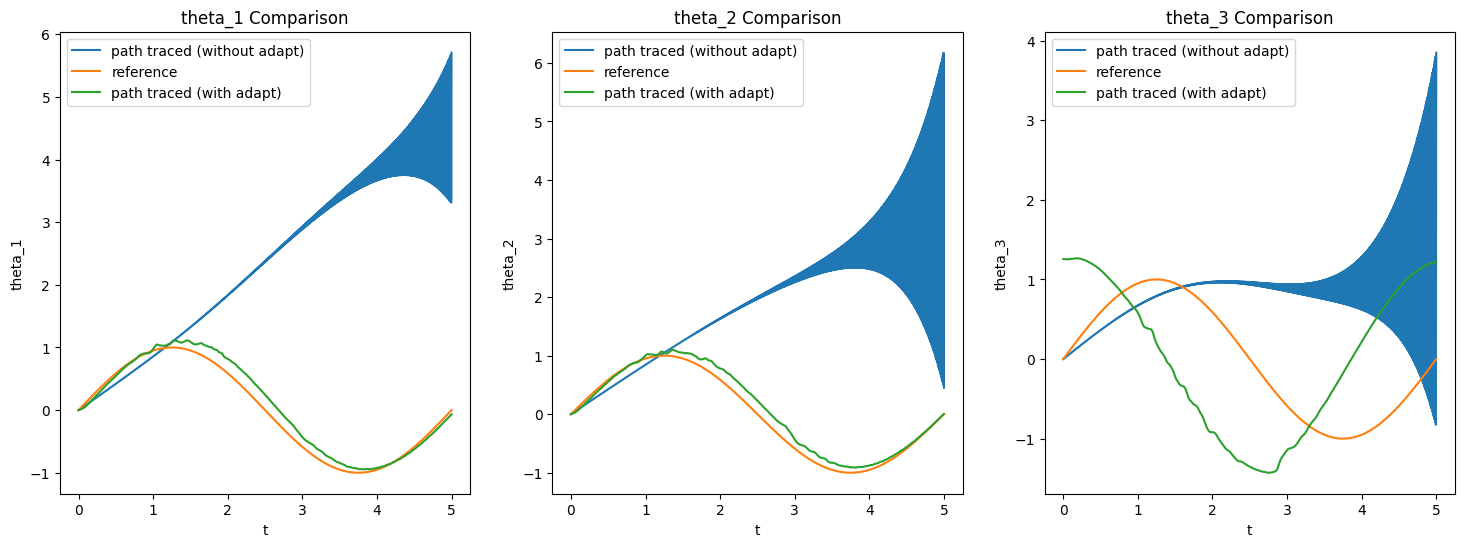

In [311]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(t_eval, xt_no_adapt[:,0], label='path traced (without adapt)')
plt.plot(t_eval, x_ref[0,:], label="reference")
plt.plot(t_eval, xt[:,0],label ='path traced (with adapt)')
plt.xlabel('t')
plt.ylabel('theta_1')
plt.title('theta_1 Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(t_eval, xt_no_adapt[:,1], label='path traced (without adapt)')
plt.plot(t_eval, x_ref[1,:], label="reference")
plt.plot(t_eval, xt[:,1],label ='path traced (with adapt)')
plt.xlabel('t')
plt.ylabel('theta_2')
plt.title('theta_2 Comparison')
plt.legend()

plt.subplot(1,3,3)
plt.plot(t_eval, xt_no_adapt[:,2], label='path traced (without adapt)')
plt.plot(t_eval, x_ref[2,:], label="reference")
plt.plot(t_eval, xt[:,3],label ='path traced (with adapt)')
plt.xlabel('t')
plt.ylabel('theta_3')
plt.title('theta_3 Comparison')
plt.legend()

In [309]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(t_eval, xt_no_adapt[:,3], label='path traced (without adapt)')
plt.plot(t_eval, x_ref[3,:], label="reference")
plt.plot(t_eval, xt[:,3],label ='path traced (with adapt)')
plt.xlabel('t')
plt.ylabel('theta_1_dot')
plt.title('theta_1_dot Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(t_eval, xt_no_adapt[:,4], label='path traced (without adapt)')
plt.plot(t_eval, x_ref[4,:], label="reference")
plt.plot(t_eval, xt[:,4],label ='path traced (with adapt)'
plt.xlabel('t')
plt.ylabel('theta_2_dot')
plt.title('theta_2_dot Comparison')
plt.legend()

plt.subplot(1,3,3)
plt.plot(t_eval, xt_no_adapt[:,5], label='path traced (without adapt)')
plt.plot(t_eval, x_ref[5,:], label="reference")
plt.plot(t_eval, xt[:,5],label ='path traced (with adapt)')
plt.xlabel('t')
plt.ylabel('theta_3_dot')
plt.title('theta_3_dot Comparison')
plt.legend()

SyntaxError: invalid syntax (1671874421.py, line 15)

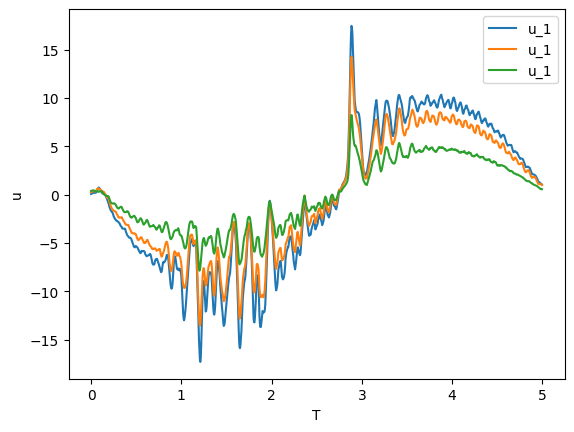

In [302]:
plt.figure()
plt.plot(t_eval[0:-1], u,label ='u_1')
plt.xlabel('T')
plt.ylabel("u")
plt.legend()
plt.savefig('control.pdf')

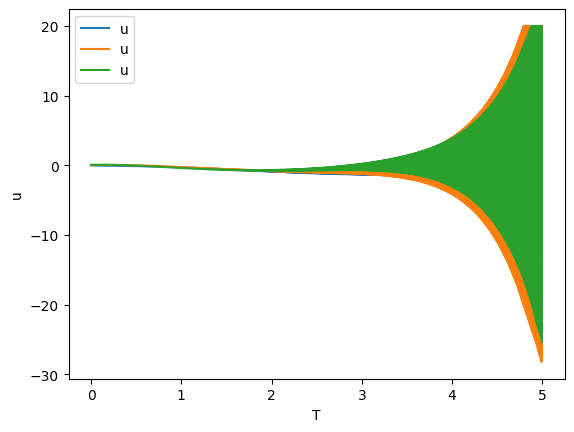

In [303]:
plt.figure()
plt.plot(t_eval[0:-1], u_no_adapt,label ='u')
plt.xlabel('T')
plt.ylabel("u")
plt.legend()
plt.savefig('control.pdf')

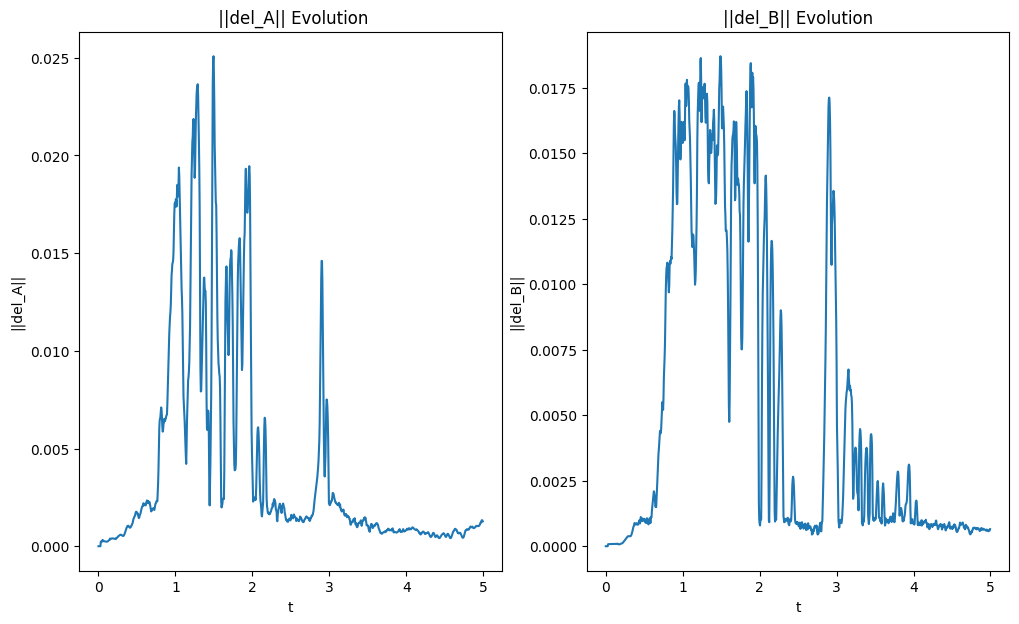

In [304]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title(" ||del_A|| Evolution")
axs[1].set_title("||del_B|| Evolution")

axs[0].set(xlabel = 't', ylabel = '||del_A||')
axs[1].set(xlabel = 't', ylabel = '||del_B||')


axs[0].plot(t_eval[:-1],del_A_norm)

axs[1].plot(t_eval[:-1],del_B_norm)
plt.show()

# Error Comparisons

In [305]:

error_dynamics_adapt = np.linalg.norm((xt.T-x_ref),axis=0)
error_dynamics_no_adapt = np.linalg.norm((xt_no_adapt.T-x_ref),axis=0)

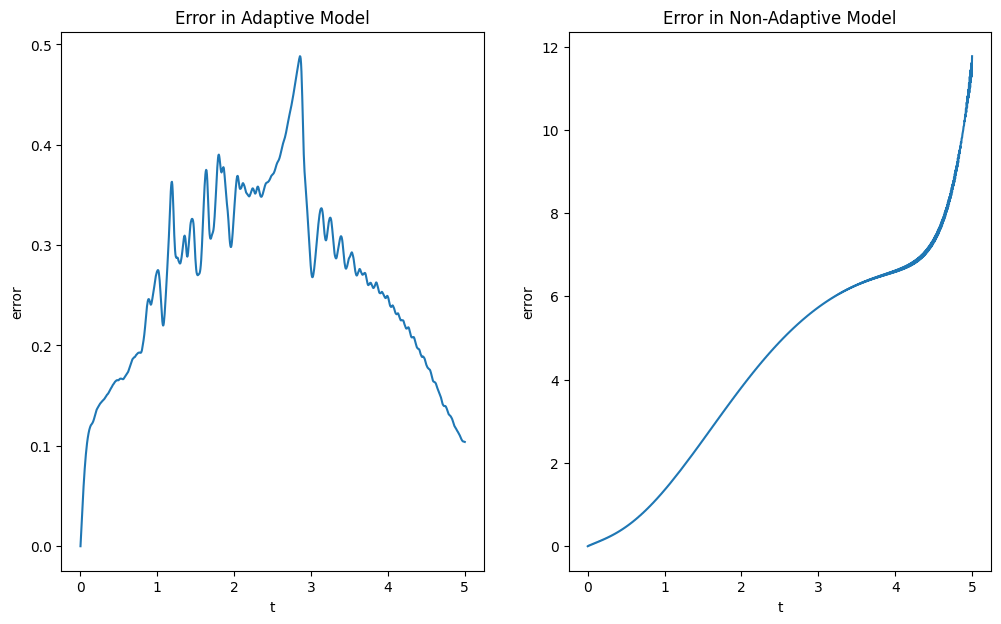

In [306]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Error in Adaptive Model")
axs[1].set_title("Error in Non-Adaptive Model")

axs[0].set(xlabel = 't', ylabel = 'error')
axs[1].set(xlabel = 't', ylabel = 'error')


axs[0].plot(t_eval,error_dynamics_adapt)

axs[1].plot(t_eval,error_dynamics_no_adapt)

plt.savefig('adap_error_comp.pdf')